In [29]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
from planning.representation import get_planning_problem
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS

In [30]:
_LOSS_CUTOFF = 0.001
_SAVE_DIR = f"../trained_models_gnn_e{_LOSS_CUTOFF}"
os.makedirs(_SAVE_DIR, exist_ok=True)

In [31]:

def generate_bitmasks(n):
    if n <= 0:
        return []

    bitmasks = []
    for i in range(1, 2**n):
        bitmask = bin(i)[2:].zfill(n)
        bitmasks.append(bitmask)
    
    return bitmasks

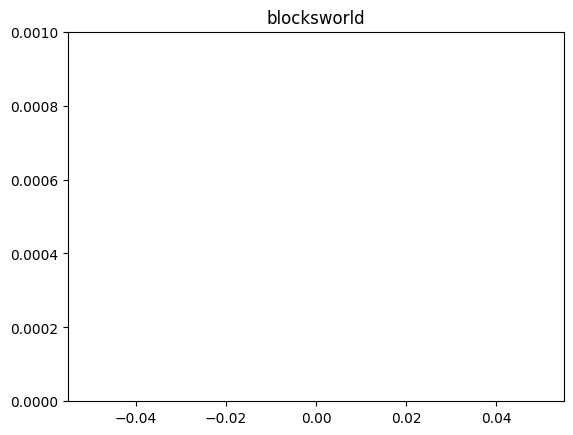

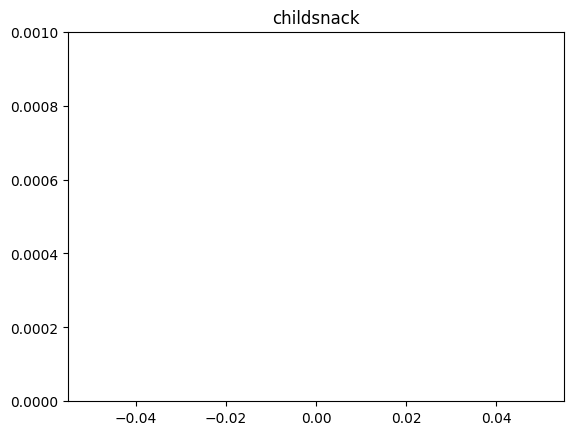

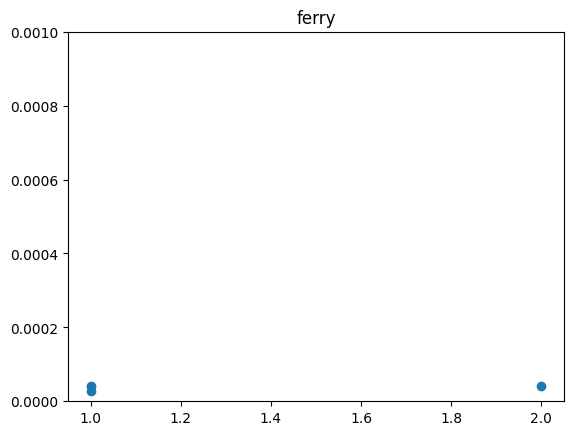

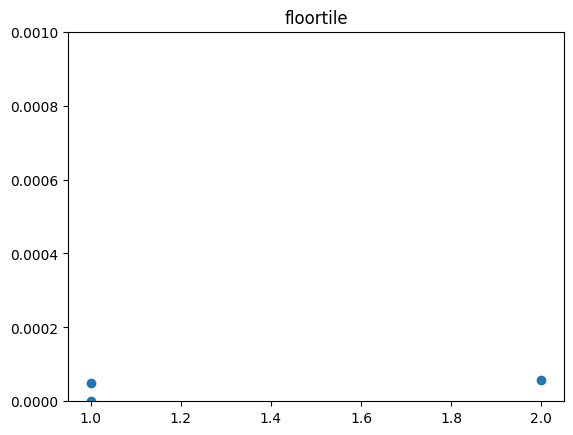

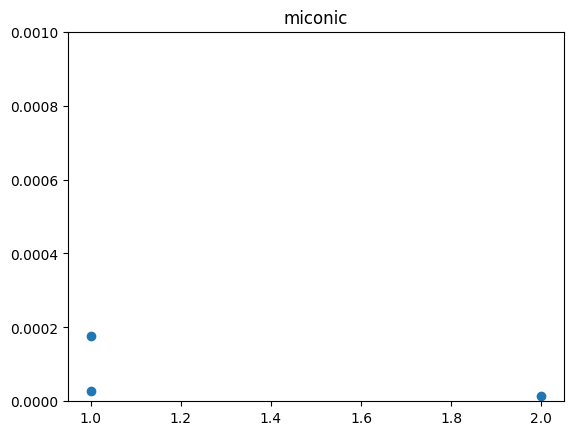

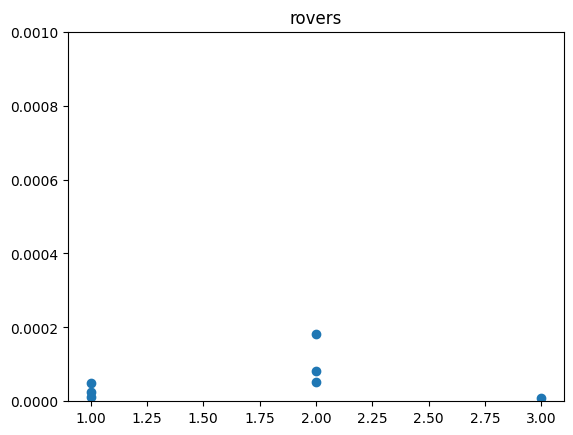

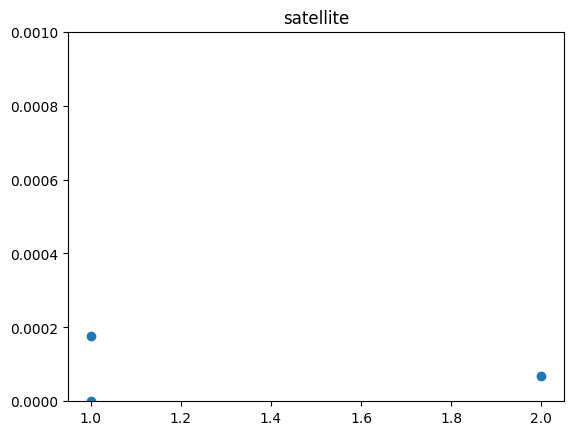

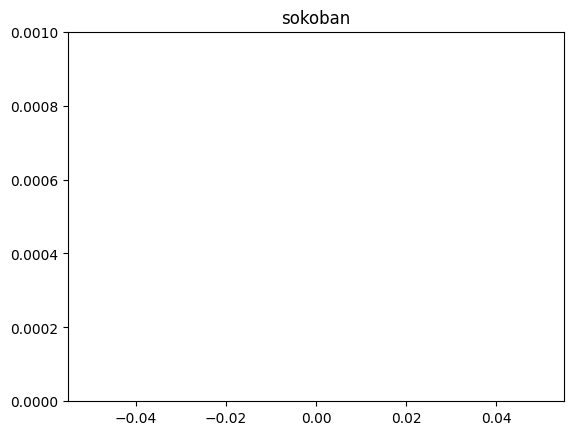

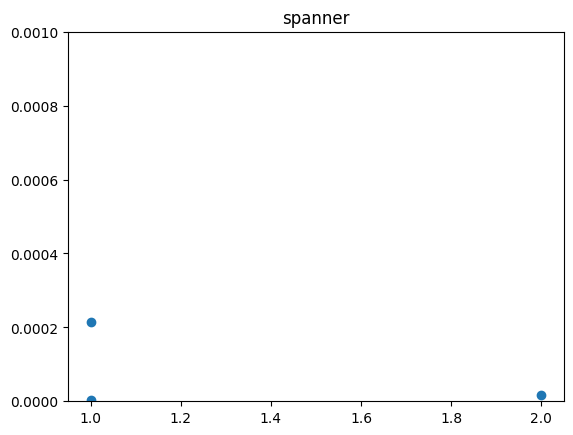

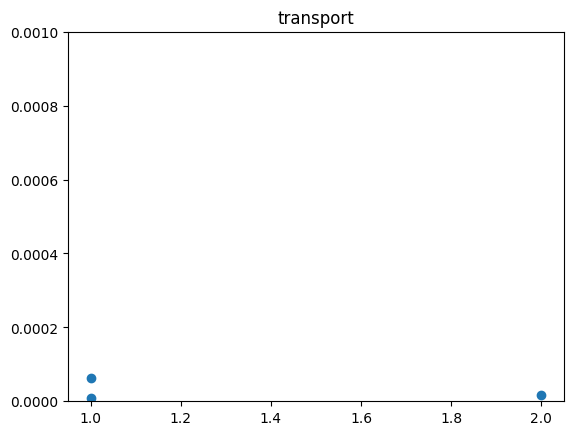

<Figure size 640x480 with 0 Axes>

In [32]:
best_models = []
for domain, n_bitmasks in IPC2023_LEARNING_DOMAINS.items():
    problem = get_planning_problem(
        f"../../benchmarks/ipc2023-learning-benchmarks/{domain}/domain.pddl",
        f"../../benchmarks/ipc2023-learning-benchmarks/{domain}/training/easy/p01.pddl",
    )
    idx_to_schema = sorted([a.name for a in problem.actions])

    xs_map = {s: [] for s in idx_to_schema}
    ys_map = {s: [] for s in idx_to_schema}

    xs = []
    ys = []
    best_model = None
    best_model_x = 0
    best_model_y = float("inf")
    for bitmask in generate_bitmasks(n_bitmasks):
        log_file = f"../logs_gnn_train_bitmask/{domain}-{bitmask}.log"
        if not os.path.exists(log_file):
            continue
        for line in open(log_file, "rb").readlines():
            if b"best_weighted_loss" in line:
                cnt = bitmask.count("1")
                loss = float(line.split()[1])
                if loss > _LOSS_CUTOFF:
                    continue
                xs.append(cnt)
                ys.append(loss)

                if cnt > best_model_x or (cnt == best_model_x and loss < best_model_y):
                    best_model = os.path.basename(log_file).replace(".log", "")
                    best_model_x = cnt
                    best_model_y = loss

                for i, c in enumerate(bitmask):
                    if c == "1":
                        xs_map[idx_to_schema[i]].append(cnt)
                        ys_map[idx_to_schema[i]].append(loss)

    plt.scatter(xs, ys)
    plt.title(domain)
    plt.ylim(bottom=0, top=_LOSS_CUTOFF)
    plt.show()
    plt.clf()

    if best_model is not None:
        best_models.append(best_model)

    # for schema in idx_to_schema:
    #     xs = xs_map[schema]
    #     ys = ys_map[schema]
    #     plt.scatter(xs, ys)
    #     plt.title(domain+" "+schema)
    #     plt.ylim(bottom=0, top=0.2)
    #     plt.show()
    #     plt.clf()

In [33]:
best_models

['ferry-110',
 'floortile-0000011',
 'miconic-1100',
 'rovers-110000001',
 'satellite-01010',
 'spanner-110',
 'transport-011']

In [34]:
for model in best_models:
    cmd = f"scp cluster1:~/goose/learner/trained_models_gnn/{model}.dt {_SAVE_DIR}"
    os.system(cmd)